In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [220]:
DIRECTORY = './data/'
categories = pd.read_csv(DIRECTORY + 'item_categories.csv')
items = pd.read_csv(DIRECTORY + 'items.csv')
shops = pd.read_csv(DIRECTORY + 'shops.csv')
train = pd.read_csv(DIRECTORY + 'sales_train.csv', parse_dates=['date'], date_format='%d.%m.%Y')
test = pd.read_csv(DIRECTORY + 'test.csv')
train['month'] = train['date'].dt.to_period('M')

# 1. Test new items

In [221]:
# get new items in 
new_items = np.setdiff1d(test['item_id'].unique(), train['item_id'].unique())
len(new_items)

363

In [222]:
# Count of each item subcategory
items['subcategory'] = items['item_name'].str.split().str[0]
count_categories = items['subcategory'].value_counts()
pd.cut(count_categories, bins=[0,1,2,3,5,10,100,1000]).value_counts(normalize=True)

count
(0, 1]         0.472391
(1, 2]         0.195925
(2, 3]         0.098819
(3, 5]         0.091965
(5, 10]        0.075400
(10, 100]      0.063024
(100, 1000]    0.002475
Name: proportion, dtype: float64

In [223]:
# Count of category first words (bigcategory)
categories['category_first_word'] = categories['item_category_name'].str.split().str[0]
count_bigcategories = categories['category_first_word'].value_counts()
pd.cut(count_bigcategories, bins=[0,1,2,3,4,5,6,7,50]).value_counts(normalize=True).sort_index()

count
(0, 1]     0.266667
(1, 2]     0.133333
(2, 3]     0.000000
(3, 4]     0.000000
(4, 5]     0.133333
(5, 6]     0.133333
(6, 7]     0.066667
(7, 50]    0.266667
Name: proportion, dtype: float64

In [224]:
# Item name first word + inside brackets
items['bracket'] = items['item_name'].str.extract(r'\[(.*?)\]').fillna('')
items['first_and_bracket'] = items['subcategory'].str.cat(items['bracket'], sep='-')
items['first_two_words'] = items['item_name'].str.split().str[:2].str.join(' ')
items['first_two_and_bracket'] = items['first_two_words'].str.cat(items['bracket'], sep='-')
items['before_bracket'] = items['item_name'].str.split('[').str[0].str.split().str[-2:].str.join(' ')
items['relevant_string'] = items['first_two_and_bracket'] + items['before_bracket']

# Nov. 2014 Testing

In [225]:
# Try testing on Nov. 2014
# predict the avg. of the ones with the same first name
# predict avg. of ones in same category

nov = pd.to_datetime('2014-11-01').to_period('M')
nov_train = train[train['month'] == nov]
nov_new_items = np.setdiff1d(nov_train['item_id'].unique(), train[train['month'] < nov]['item_id'].unique())
nov_stores = nov_train['shop_id'].unique()
nov_train_new = nov_train[nov_train['item_id'].isin(nov_new_items)]

In [226]:
nov_train_aggregated = nov_train_new.groupby(['shop_id', 'item_id'])['item_cnt_day'].sum().to_frame('answers').reset_index()
nov_train_aggregated['clipped'] = np.clip(nov_train_aggregated['answers'], 0, 20)
np.square(nov_train_aggregated['clipped']).sum() / len(nov_stores) / len(nov_new_items)

10.711347826086957

In [227]:
# Guessing a constant value (only down to 9.7)
guess = nov_train_aggregated['clipped'].sum() / len(nov_stores) / len(nov_new_items)
np.square(nov_train_aggregated['clipped'] - 1).sum() / len(nov_stores) / len(nov_new_items) + 1 - len(nov_train_aggregated) / len(nov_stores) / len(nov_new_items)

9.694565217391306

In [228]:
# Guess based on previous first month sales
before_nov = train[train['month'] < nov].copy()

# calculate first month sales for each item, before grouping by item first name
first_month_map = before_nov.groupby(['item_id'])['month'].min() # for each item, get its first month
before_nov['first_month'] = before_nov['item_id'].map(first_month_map)
first_month_sales = before_nov[before_nov['month'] == before_nov['first_month']].groupby(['item_id', 'shop_id'])['item_cnt_day'].sum().to_frame('first_month_sales').reset_index()
first_month_sales = first_month_sales.merge(items, on=['item_id'], how='left').merge(categories, on=['item_category_id'])
first_month_sales['first_month_sales'] = np.clip(first_month_sales['first_month_sales'], 0, 20)
# by category, and by subcategory

by_category = first_month_sales.groupby(['item_category_id', 'shop_id'])['first_month_sales'].mean().to_frame('prediction_category').reset_index()
by_category['prediction_category'] = np.clip(by_category['prediction_category'], 0, 20)

by_subcategory = first_month_sales.groupby(['subcategory', 'shop_id'])['first_month_sales'].mean().to_frame('prediction_subcategory').reset_index()
by_subcategory['prediction_subcategory'] = np.clip(by_subcategory['prediction_subcategory'], 0, 20)

by_bigcategory = first_month_sales.groupby(['category_first_word', 'shop_id'])['first_month_sales'].mean().to_frame('prediction_bigcategory').reset_index()
by_bigcategory['prediction_bigcategory'] = np.clip(by_bigcategory['prediction_bigcategory'], 0, 20)

by_other = first_month_sales.groupby(['first_two_and_bracket', 'shop_id'])['first_month_sales'].mean().to_frame('prediction_first_and_bracket').reset_index()
by_other['prediction_first_and_bracket'] = np.clip(by_other['prediction_first_and_bracket'], 0, 20)

by_rel = first_month_sales.groupby(['relevant_string', 'shop_id'])['first_month_sales'].mean().to_frame('prediction_relevant').reset_index()
by_rel['prediction_relevant'] = np.clip(by_rel['prediction_relevant'], 0, 20)


In [229]:
# guessing avg. of first month for same category
prediction_df = pd.DataFrame(data=itertools.product(nov_stores, nov_new_items), columns=['shop_id', 'item_id'])
prediction_df = prediction_df.merge(nov_train_aggregated, on=['shop_id', 'item_id'], how='left')
prediction_df = prediction_df.merge(items, on=['item_id'], how='left').merge(categories, on=['item_category_id'])
prediction_df = prediction_df.merge(by_category, on=['item_category_id', 'shop_id'], how='left') # add in each of the 3 predictions
prediction_df = prediction_df.merge(by_subcategory, on=['subcategory', 'shop_id'], how='left')
prediction_df = prediction_df.merge(by_bigcategory, on=['category_first_word', 'shop_id'], how='left')
prediction_df = prediction_df.merge(by_other, on=['first_two_and_bracket', 'shop_id'], how='left')
prediction_df = prediction_df.merge(by_rel, on=['relevant_string', 'shop_id'], how='left')


prediction_df['prediction_baseline'] = 0
prediction_cols = [col for col in prediction_df.columns if 'prediction' in col]
# prediction_df['prediction_combined'] = np.where(prediction_df['item_category_id'].isin([20,28,29]), 5, 0)
prediction_df['prediction_combined'] = np.where(prediction_df['prediction_relevant'].isna(), prediction_df['prediction_category'], prediction_df['prediction_relevant'])
prediction_df = prediction_df.fillna(0)

print("Baseline:", np.square(prediction_df['clipped'].fillna(0)).sum() / len(nov_stores) / len(nov_new_items))
print("Category:", np.square(prediction_df['clipped'].fillna(0) - prediction_df['prediction_category'].fillna(0)).sum() / len(prediction_df))
print("Big category:", np.square(prediction_df['clipped'].fillna(0) - prediction_df['prediction_bigcategory'].fillna(0)).sum() / len(nov_stores) / len(nov_new_items))
print("Subcategory:", np.square(prediction_df['clipped'].fillna(0) - prediction_df['prediction_subcategory'].fillna(0)).sum() / len(nov_stores) / len(nov_new_items))
print("First and Bracket:", np.square(prediction_df['clipped'].fillna(0) - prediction_df['prediction_first_and_bracket'].fillna(0)).sum() / len(nov_stores) / len(nov_new_items))
print("Relevant:", np.square(prediction_df['clipped'].fillna(0) - prediction_df['prediction_relevant'].fillna(0)).sum() / len(nov_stores) / len(nov_new_items))
print("Combined:", np.square(prediction_df['clipped'].fillna(0) - prediction_df['prediction_combined'].fillna(0)).sum() / len(nov_stores) / len(nov_new_items))

Baseline: 10.711347826086957
Category: 7.898373095853452
Big category: 11.856404144110979
Subcategory: 12.588833084857201
First and Bracket: 10.866759403592706
Relevant: 10.72985890610935
Combined: 7.907775393588241


# Investigating shortcomings

In [230]:
prediction_df['error'] = prediction_df['clipped'] - prediction_df['prediction_category']
prediction_df['squared_error'] = (prediction_df['clipped'] - prediction_df['prediction_first_and_bracket'])**2
prediction_df['error_bins'] = pd.cut(prediction_df['error'], [-30, -10, -5, -2, -1, -0.01, 0.01, 1, 2, 5, 10, 20])
prediction_df['error_bins'].value_counts().sort_index()

error_bins
(-30.0, -10.0]      86
(-10.0, -5.0]      755
(-5.0, -2.0]      3715
(-2.0, -1.0]      8896
(-1.0, -0.01]     1326
(-0.01, 0.01]     6121
(0.01, 1.0]        618
(1.0, 2.0]         313
(2.0, 5.0]         513
(5.0, 10.0]        312
(10.0, 20.0]       345
Name: count, dtype: int64

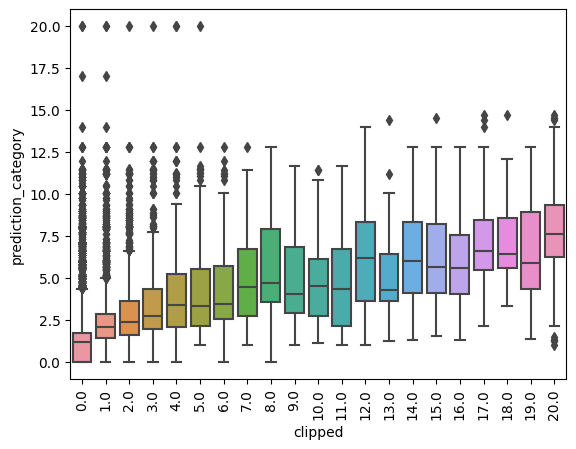

In [231]:
sns.boxplot(data=prediction_df, x='clipped', y='prediction_category')
plt.xticks(rotation=90);

In [232]:
# For each prediciotn, by answer value

error_cols = []
for col in prediction_df.columns:
    if 'prediction' not in col: continue
    error_col_name = f'mse{col.replace('prediction', '')}'
    prediction_df[error_col_name] = (prediction_df[col] - prediction_df['clipped'])**2
    error_cols.append(error_col_name)

prediction_df
display(prediction_df.groupby(by='clipped')[error_cols].agg(['mean', 'count', 'sum']))
# print("Total error:", prediction_df['squared_error'].sum())

mse_category                      mse_subcategory         \
                mean  count           sum            mean  count   
clipped                                                            
0.0         3.933796  17651  69435.436938        7.602535  17651   
1.0         7.238369   2094  15157.144763        6.781768   2094   
2.0         6.561171    945   6200.306184        7.554455    945   
3.0         7.011542    495   3470.713308       10.617101    495   
4.0         7.904086    355   2805.950652       10.690245    355   
5.0         8.916148    256   2282.533993       14.017917    256   
6.0         9.259763    178   1648.237830       15.775198    178   
7.0        11.536275    139   1603.542246       23.069943    139   
8.0        13.668172    118   1612.844340       27.591341    118   
9.0        23.842455     85   2026.608695       37.383338     85   
10.0       31.584158     72   2274.059362       54.054699     72   
11.0       46.172386     63   2908.860298       69.349605     63   
12.0       42.607306     38   1619.077617       79.792251     38   
13.0       68.376180     29   1982.909206      105.754124     29   
14.0       65.082788     36   2342.980379      111.714838     36   
15.0       85.434613     26   2221.299950      145.659550     26   
16.0      105.098510     29   3047.856795      155.897671     29   
17.0      107.257119     30   3217.713581      172.478923     30   
18.0      125.345023     20   2506.900458      216.345273     20   
19.0      162.408692     20   3248.173842      260.839629     20   
20.0      155.917230    321  50049.430768      210.329456    321   

                       mse_bigcategory                        \
                   sum            mean  count            sum   
clipped                                                        
0.0      134192.347016        7.976785  17651  140798.231093   
1.0       14201.021594        5.034858   2094   10542.992175   
2.0        7138.959554        3.003217    945    2838.039699   
3.0        5255.465235        2.080893    495    1030.041908   
4.0        3795.037042        2.156268    355     765.475075   
5.0        3588.586773        4.032510    256    1032.322450   
6.0        2807.985226        7.064376    178    1257.458952   
7.0        3206.722038       11.299221    139    1570.591778   
8.0        3255.778250       15.416814    118    1819.184096   
9.0        3177.583727       26.469603     85    2249.916291   
10.0       3891.938305       36.380292     72    2619.380996   
11.0       4369.025095       55.672707     63    3507.380548   
12.0       3032.105527       63.064386     38    2396.446672   
13.0       3066.869584       81.169620     29    2353.918971   
14.0       4021.734162       93.097048     36    3351.493718   
15.0       3787.148296      114.671424     26    2981.457028   
16.0       4521.032461      134.773859     29    3908.441910   
17.0       5174.367704      158.684454     30    4760.533608   
18.0       4326.905463      182.962028     20    3659.240558   
19.0       5216.792575      220.998630     20    4419.972597   
20.0      67515.755322      233.130141    321   74834.775190   

        mse_first_and_bracket                       mse_relevant         \
                         mean  count            sum         mean  count   
clipped                                                                   
0.0                  1.386602  17651   24474.919440     0.009393  17651   
1.0                  3.243374   2094    6791.625617     1.194283   2094   
2.0                  5.654778    945    5343.764872     4.032180    945   
3.0                 11.771418    495    5826.851870     8.945960    495   
4.0                 14.937739    355    5302.897483    16.000000    355   
5.0                 22.285987    256    5705.212743    25.000000    256   
6.0                 31.096388    178    5535.157035    35.887640    178   
7.0                 40.973270    139    5695.284584    48.859492    139   
8.0          

In [233]:
# By prediction value
prediction_buckets = pd.cut(prediction_df['prediction_category'], bins=[0, 0.9, 1, 2, 3, 4, 5, 10, 15, 20], include_lowest=True)
display(prediction_df.groupby(prediction_buckets)['squared_error'].agg(['mean', 'count', 'sum']))
print("Total error:", prediction_df['squared_error'].sum())

/var/folders/_c/j62lsd3n7x9_vq272kdsl3fc0000gn/T/ipykernel_16852/2033657166.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(prediction_df.groupby(prediction_buckets)['squared_error'].agg(['mean', 'count', 'sum']))


,mean,count,sum
prediction_category,,,
"(-0.001, 0.9]",0.066412,6051,401.856667
"(0.9, 1.0]",1.287630,2010,2588.136877
"(1.0, 2.0]",1.745904,7826,13663.448242
"(2.0, 3.0]",6.775735,3461,23450.818643
"(3.0, 4.0]",16.965415,1068,18119.062862
"(4.0, 5.0]",38.513212,741,28538.290425
"(5.0, 10.0]",82.736362,1537,127165.788269
"(10.0, 15.0]",121.853278,295,35946.717075
"(15.0, 20.0]",5.577020,11,61.347222


Total error: 249935.46628263226


In [234]:
prediction_df.groupby(by='item_id')['squared_error'].sum().sort_values(ascending=False).head(20)

item_id
3733     18630.000000
1556     17161.000000
1555     17127.000000
2293     14949.000000
3462     14626.000000
3460     11070.722222
7863     10570.000000
3031      6538.000000
3027      6126.000000
2288      5679.000000
7861      5543.000000
1564      4457.000000
1549      3754.000000
1548      3675.000000
5836      3494.500000
5832      3490.500000
1569      3445.000000
5833      3337.500000
5834      3238.500000
13560     3105.000000
Name: squared_error, dtype: float64

In [236]:
first_two_curr = items[items['item_id'] == 1555]['first_two_and_bracket'].iloc[0]
assassins = items[items['first_two_and_bracket'] == first_two_curr]
assassins_predictions = pd.merge(prediction_df, assassins, on='item_id').groupby(['item_id', 'shop_id'])[['clipped', 'prediction_combined']].sum()
assassins_predictions.groupby('item_id').sum()

,clipped,prediction_combined
item_id,,
1548,311.0,375.669867
1555,901.0,320.953740


In [237]:
# look at the items getting 20s
high_items = prediction_df[prediction_df['clipped'] == 20]['item_id'].unique()
print("# Items getting 20s:", len(high_items))
prediction_df[prediction_df['clipped'] == 20].groupby('item_id')['shop_id'].count().sort_values(ascending=False)

# Items getting 20s: 44


item_id
3733     46
2293     39
1556     38
1555     36
3460     35
3462     26
7863     15
2288     11
7861      9
3031      7
1564      4
1569      4
3027      4
13560     3
1548      3
2285      3
1549      3
18148     2
20404     2
5490      2
5319      2
21387     2
3461      2
3447      2
2283      2
10518     1
20405     1
1553      1
1565      1
17138     1
16628     1
15704     1
15544     1
1570      1
10205     1
3463      1
2295      1
3403      1
4479      1
3735      1
3449      1
3537      1
3466      1
1542      1
Name: shop_id, dtype: int64

In [238]:
# 20, 28, 29, 30 as expected
prediction_df.groupby('item_category_id')['clipped'].mean().sort_values(ascending=False)

item_category_id
28    9.745000
29    6.100000
20    5.419048
30    3.093333
19    2.615714
38    2.150000
12    2.000000
56    1.930000
23    1.376471
37    1.360000
40    0.738082
55    0.688000
14    0.640000
24    0.589167
72    0.494545
41    0.480000
61    0.452500
7     0.360000
69    0.310000
22    0.300000
65    0.286667
16    0.260000
63    0.256364
70    0.130000
62    0.112000
58    0.108667
67    0.100000
31    0.096250
43    0.095000
49    0.090000
54    0.080000
64    0.060000
76    0.032000
75    0.020000
44    0.020000
45    0.020000
15    0.020000
78    0.020000
Name: clipped, dtype: float64

In [239]:
pd.set_option('display.max_columns', None)
top_game_category = prediction_df[prediction_df['item_id'] == 3733]['relevant_string'].iloc[0]
prediction_df[prediction_df['item_id'] == 3733][['clipped'] + [col for col in prediction_df.columns if 'prediction' in col]]

,clipped,prediction_category,prediction_subcategory,prediction_bigcategory,prediction_first_and_bracket,prediction_relevant,prediction_baseline,prediction_combined
105,20.0,8.073171,6.545455,4.302198,0.0,0.0,0,8.073171
565,3.0,2.375000,0.000000,2.645161,0.0,0.0,0,2.375000
1025,20.0,11.965517,9.428571,6.704632,0.0,0.0,0,11.965517
1485,20.0,10.040816,7.500000,4.493333,0.0,0.0,0,10.040816
1945,20.0,3.800000,0.000000,3.023810,0.0,0.0,0,3.800000
2405,20.0,5.093750,8.800000,3.646575,0.0,0.0,0,5.093750
2865,20.0,8.023810,6.909091,4.109415,0.0,0.0,0,8.023810
3325,20.0,8.872340,5.666667,4.543224,0.0,0.0,0,8.872340
3785,20.0,8.021739,5.714286,4.242597,0.0,0.0,0,8.021739
4245,20.0,10.830189,6.500000,5.587736,0.0,0.0,0,10.830189


In [ ]:
#